In [1]:
from dataset import MultiDSpritesGrayBackground
from model import *
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Hyperparameters.
seed = 0
batch_size = 2
num_slots = 6
num_iterations = 3
resolution = (128, 128)
hid_dim = 32
proj_dim = 1024

In [4]:
resolution = (64, 64)
model = SlotAttentionAutoEncoder(resolution, num_slots=num_slots, num_iterations=num_iterations, hid_dim=hid_dim).to(device)
model.load_state_dict(torch.load('../../multidsprite-k6h32-reproduce', map_location="cpu")['model_state_dict'])

<All keys matched successfully>

In [5]:
test_set = MultiDSpritesGrayBackground("../../multidsprite_grayscale")
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)

In [6]:
model = model.to(device)
model.eval()
images = next(iter(test_loader))['image'].to(device)
recon_combineds, recons, masks, slots = model(images)

torch.Size([3, 134, 530])


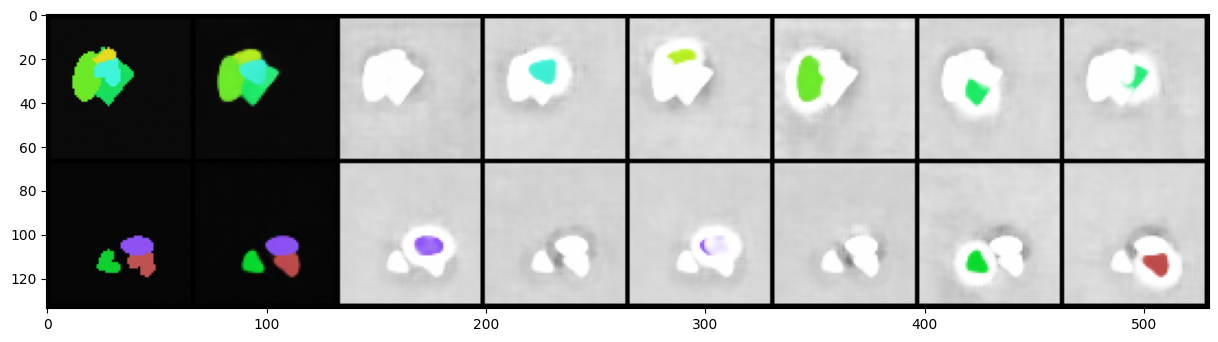

In [8]:
images_to_show = []
for i, image in enumerate(images):
    image = image.cpu()
    recon_combined = recon_combineds[i].cpu().detach()
    recon = recons[i].permute(0,3,1,2).cpu().detach()
    mask = masks[i].permute(0,3,1,2).cpu().detach()

    images_to_show.append(image)
    images_to_show.append(recon_combined)
    
    for j in range(num_slots):
        picture = recon[j] * mask[j] + (1 - mask[j])
        images_to_show.append(picture)

images_to_show = torchvision.utils.make_grid(images_to_show, nrow=num_slots+2)
print(images_to_show.shape)

plt.figure(figsize=(15,2*batch_size))
plt.imshow(images_to_show.permute(1,2,0))
#plt.savefig(os.path.join(args.image_dir, 'reconstructions_{}.png'.format(epoch)))

In [10]:
from metrics import adjusted_rand_index

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ari_mean = 0
num_batches = 0
for batch in test_loader:
    images = batch['image'].to(device)
    true_mask = batch['mask'].to(device)
    recon_combineds, recons, masks, slots = model(images)
    # `masks` has shape: [batch_size, num_slots, width, height, 1].
    # CHECK: `true_mask` has shape: [batch_size, num_entities, width, height].
    # CHECK: true mask is one_hot
    # true_mask = torch.flatten(true_mask, start_dim = 1, end_dim=2)
    flattened_masks = torch.flatten(masks, start_dim=2, end_dim=4)
    flattened_masks = torch.permute(flattened_masks, (0, 2, 1))
    ari = adjusted_rand_index(true_mask, flattened_masks)
    ari_mean += ari.mean().item()
    print(ari)
    num_batches += 1
    if num_batches*batch_size > 320:
        break
print("Ari: ", ari_mean / num_batches)

tensor([0.9166, 0.5296])
tensor([0.6435, 0.9115])
tensor([0.9334, 0.9640])
tensor([0.8942, 0.7843])
tensor([0.9746, 0.7480])
tensor([0.9658, 0.9492])
tensor([0.9740, 0.7421])
tensor([0.6805, 0.8444])
tensor([0.3250, 0.9590])
tensor([0.7155, 0.9621])
tensor([0.8349, 0.9039])
tensor([0.6457, 0.8032])
tensor([0.4354, 0.9391])
tensor([0.9561, 0.8768])
tensor([0.9936, 0.3765])
tensor([0.6270, 0.8281])
tensor([0.8667, 0.5550])
tensor([0.8783, 0.9689])
tensor([0.8336, 0.9278])
tensor([0.0865, 0.9446])
tensor([0.8920, 0.6973])
tensor([0.8857, 0.8526])
tensor([0.8483, 0.7281])
tensor([0.8339, 0.7250])
tensor([0.6162, 0.9638])
tensor([0.9458, 0.8367])
tensor([0.9780, 0.8996])
tensor([0.9389, 0.7295])
tensor([0.9934, 1.0000])
tensor([0.9935, 0.9538])
tensor([0.8683, 0.8724])
tensor([0.9353, 0.9320])
tensor([0.7160, 0.9521])
tensor([0.9787, 0.9231])
tensor([0.7983, 0.4342])
tensor([0.5148, 0.8984])
tensor([0.9278, 0.8547])
tensor([0.8262, 0.9504])
tensor([0.6515, 0.8399])
tensor([0.7694, 0.6040])
